In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SIFTPanoStitcher:
    def __init__(self):
        self.sift = cv2.SIFT_create()
        self.matcher = cv2.BFMatcher()
        
    def load_images(self, path1, path2):
        self.img1 = cv2.imread(path1)
        self.img2 = cv2.imread(path2)
        
        if self.img1 is None or self.img2 is None:
            raise ValueError("file not found.")
            
        self.gray1 = cv2.cvtColor(self.img1, cv2.COLOR_BGR2GRAY)
        self.gray2 = cv2.cvtColor(self.img2, cv2.COLOR_BGR2GRAY)
        
        # Konversi ke RGB untuk plotting Matplotlib
        self.img1_rgb = cv2.cvtColor(self.img1, cv2.COLOR_BGR2RGB)
        self.img2_rgb = cv2.cvtColor(self.img2, cv2.COLOR_BGR2RGB)
        
        return self.img1, self.img2

    def detect_and_describe(self):
        self.kp1, self.des1 = self.sift.detectAndCompute(self.gray1, None)
        self.kp2, self.des2 = self.sift.detectAndCompute(self.gray2, None)
        
        print(f"Keypoints 1: {len(self.kp1)}")
        print(f"Keypoints 2: {len(self.kp2)}")
        
        return (self.kp1, self.des1), (self.kp2, self.des2)

    def match_features(self, ratio=0.75):
        raw_matches = self.matcher.knnMatch(self.des1, self.des2, k=2)
        
        self.good_matches = []
        for m, n in raw_matches:
            if m.distance < ratio * n.distance:
                self.good_matches.append(m)
                
        print(f"Good Matches: {len(self.good_matches)}")
        return self.good_matches

    def generate_panorama(self):
        if len(self.good_matches) < 4:
            print("Error.")
            return None

        src_pts = np.float32([self.kp1[m.queryIdx].pt for m in self.good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([self.kp2[m.trainIdx].pt for m in self.good_matches]).reshape(-1, 1, 2)

        self.M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

        h1, w1 = self.img1.shape[:2]
        h2, w2 = self.img2.shape[:2]

        output_width = w1 + w2
        output_height = max(h1, h2)
        
        self.result = cv2.warpPerspective(self.img2, self.M, (output_width, output_height))
        self.result[0:h1, 0:w1] = self.img1
        
        return self.result

    def visualize_all_steps(self):
        plt.figure(figsize=(20, 15))

        # 1. Visualisasi Keypoints (Citra 1)
        img_kp1 = cv2.drawKeypoints(self.gray1, self.kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.subplot(3, 1, 1)
        plt.imshow(img_kp1)
        plt.title(f"Keypoints SIFT Total: {len(self.kp1)}")
        plt.axis('off')

        # 2. Visualisasi Feature Matching
        img_matches = cv2.drawMatches(self.img1_rgb, self.kp1, self.img2_rgb, self.kp2, 
                                      self.good_matches, None, 
                                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.subplot(3, 1, 2)
        plt.imshow(img_matches)
        plt.title(f"Feature Matching Valid: {len(self.good_matches)}")
        plt.axis('off')

        # 3. Hasil Panorama Akhir
        plt.subplot(3, 1, 3)
        plt.imshow(cv2.cvtColor(self.result, cv2.COLOR_BGR2RGB))
        plt.title("Image Stitching")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

Keypoints 1: 5973
Keypoints 2: 10588
Good Matches: 668
--- Visualisasi Hasil ---


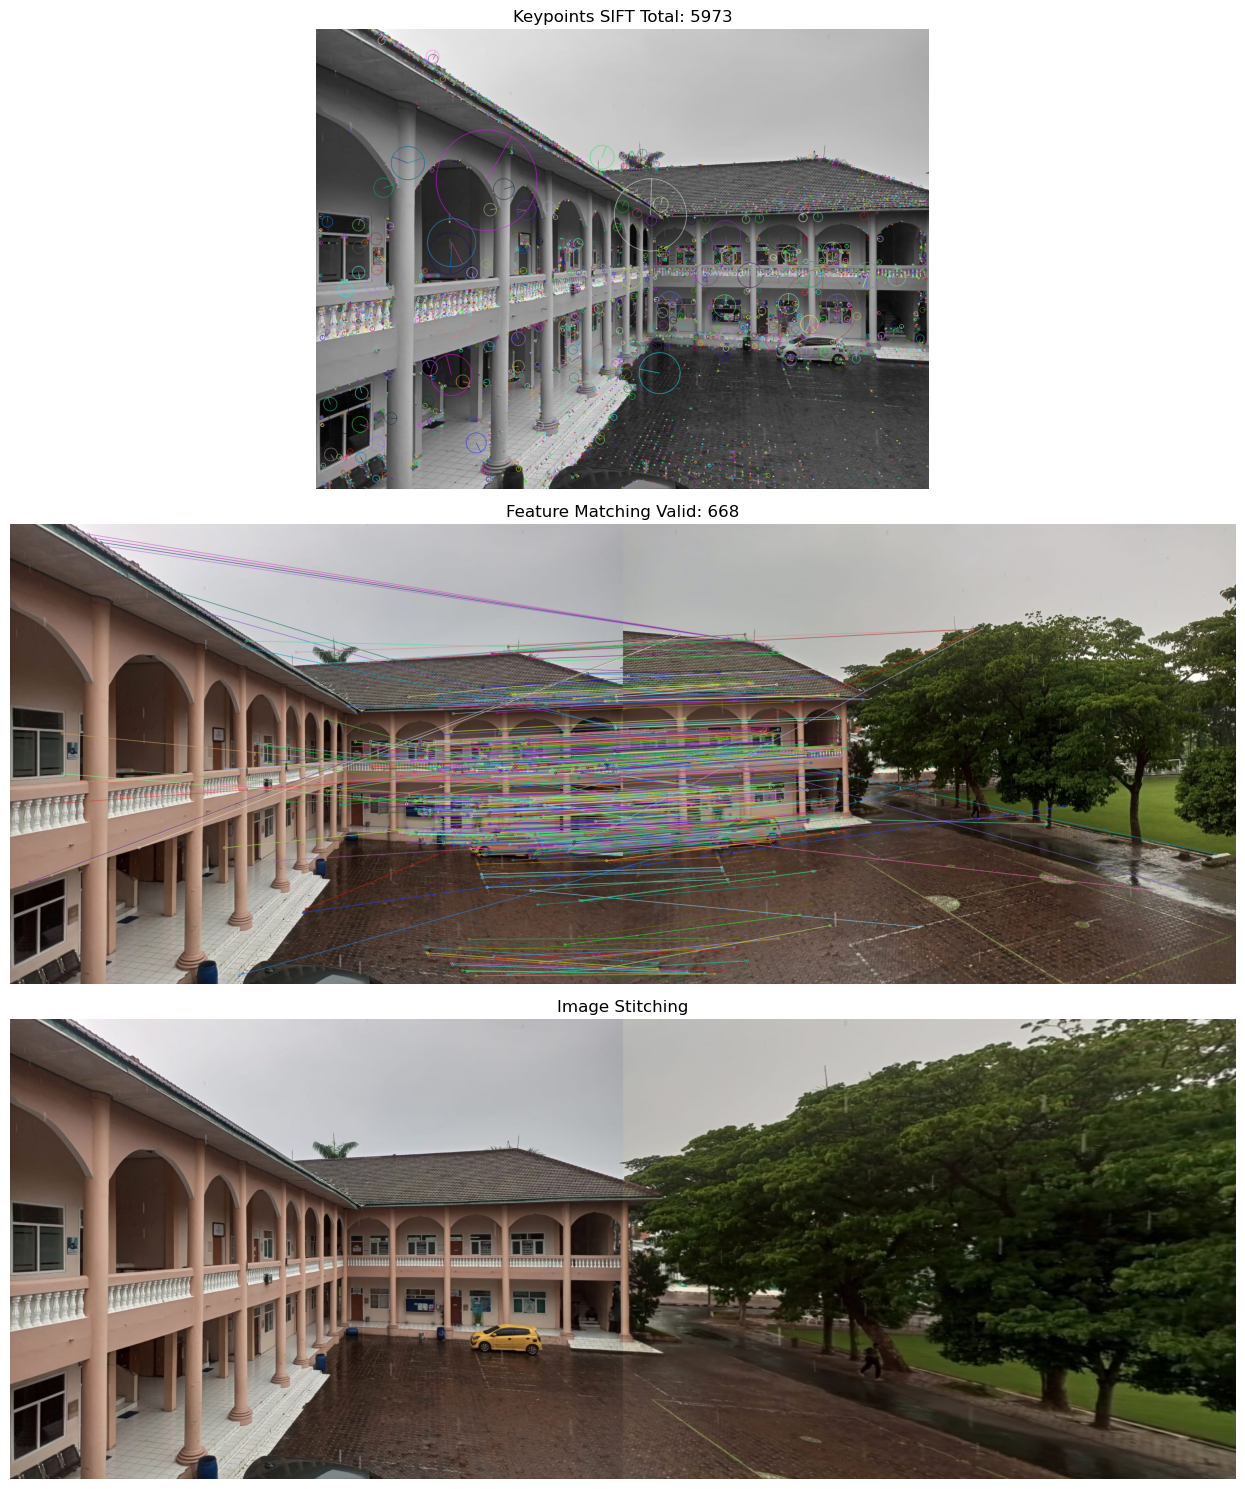

Saved as 'result/final_result.jpg'


In [3]:
FILE_1 = 'data/1.jpeg' 
FILE_2 = 'data/2.jpeg'

try:
    # Inisialisasi object
    stitcher = SIFTPanoStitcher()
    
    # Load and Detect file
    stitcher.load_images(FILE_1, FILE_2)
    stitcher.detect_and_describe()
    
    # Matching
    stitcher.match_features(ratio=0.75)
    
    # Generating
    panorama = stitcher.generate_panorama()
    
    # Visualizing
    print("--- Visualisasi Hasil ---")
    stitcher.visualize_all_steps()
    
    # Saving
    cv2.imwrite('result/final_result.jpg', panorama)
    print("Saved as 'result/final_result.jpg'")
    
except Exception as e:
    print(f"Error: {e}")